In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Load the komega dataset 
df = pd.read_csv('/kaggle/input/ml-turbulence-dataset/komega.csv')

# Turbulence closure problem

## Basic problem
The continuity and Navier-Stokes equations make up **4 equations**, and have **4 unknowns** ($p$, $u_x$, $u_y$, $u_z$). They are closed, but are expensive to solve.
$$ \nabla \cdot \vec{u} = 0$$
$$\nabla \cdot (\vec{u}\vec{u}) = - \nabla p + \nu \nabla^2\vec{u} $$
If we write these equations in terms of **averaged fields** instead, they are much cheaper to solve. We get the continuity and Reynolds-averaged Navier-Stokes equations:
$$ \nabla \cdot \vec{U} = 0$$
$$\nabla \cdot (\vec{U}\vec{U}) = - \nabla p + \nu \nabla^2\vec{U} - \nabla \cdot \tau$$


But now, we have additional unknown: $\tau$, the **Reynolds stress tensor**. The equations are **unclosed** - we have more unknowns than equations. 

We need to close the equations by expressing $\tau$ in terms of $P$, $U_x$, $U_y$, and $U_z$:

$$\tau = \tau (P, U_x, U_y,U_z)$$

The usual method to close these equations is something like this (the standard $k$-$\omega$ model):
$$
\tau = -2\nu_t S + \tfrac{2}{3}kI\\
\nu_t = \frac{k}{\omega}\\
k \text{ transport equation}\\
\omega \text{ transport equation}\\
$$

This method is called *physics-based*: we construct a closure model from physical arguments and assumptions about how the mean velocity field is related to the Reynolds stress field.

Using a *data-driven* model, we can correct the Reynolds stress field predicted by the physics-based model. Then, these corrections can be used to make the $\vec{U}$ and $p$ fields more accurate. **Our goal is to train ML models to predict an accurate value of $\tau$, given RANS flow fields from a $k$-$\omega$ simulation.** After creating this neural network, we could use it within a CFD simulation to correct the $k$-$\omega$ closure. Today, we'll just train the neural network.


# The ML turbulence dataset

This dataset contains a set of collocated RANS and DNS/LES flow fields, for several different flows.

In [17]:
df.describe()

,Unnamed: 0,komega_Cx,komega_Cy,komega_Cz,komega_Ux,komega_Uy,komega_Uz,komega_p,komega_omega,komega_epsilon,...,labels_tau_33,labels_um,labels_vm,labels_wm,labels_uu,labels_uv,labels_uw,labels_vv,labels_vw,labels_ww
count,895640.000000,895640.000000,895640.000000,895640.000000,895640.000000,895640.000000,8.956400e+05,8.956400e+05,8.956400e+05,8.956400e+05,...,895640.000000,895640.000000,895640.000000,895640.000000,895640.000000,895640.000000,8.956400e+05,8.956400e+05,8.956400e+05,895640.000000
mean,40478.489758,3.946571,0.684325,0.113767,5.402107,-0.088094,9.269814e-12,-3.535149e+00,1.412501e+04,1.876916e+02,...,0.402464,5.608039,-0.094093,-0.000001,0.705201,-0.204549,-1.359287e-06,2.871643e-01,-6.072674e-09,0.402464
std,41498.600104,5.600255,1.348276,0.198281,7.022020,0.954222,5.734052e-11,1.934176e+01,2.173288e+05,7.052611e+02,...,0.906041,7.318170,0.978417,0.001320,1.582177,0.540844,1.182863e-04,7.087897e-01,1.379124e-05,0.906041
min,0.000000,-7.264670,-0.498505,-0.498505,-2.324270,-3.306060,-7.404760e-10,-1.156080e+02,1.760090e-02,1.515230e-10,...,0.000000,-1.877020,-4.018943,-0.017167,0.000000,-4.367508,-9.489061e-04,3.161123e-14,-2.127504e-04,0.000000
25%,7721.000000,0.273305,0.019601,0.025000,0.374372,-0.091301,-1.386665e-23,-1.311517e-01,2.012923e+00,5.116180e-04,...,0.000114,0.416454,-0.092677,0.000000,0.001802,-0.124215,-3.544694e-07,1.920675e-04,0.000000e+00,0.000114
50%,28326.000000,1.250000,0.096835,0.050000,0.921961,-0.000054,0.000000e+00,-1.223980e-11,2.308175e+01,6.179465e-03,...,0.002146,0.955644,-0.000999,0.000000,0.007715,-0.000293,0.000000e+00,1.500282e-03,0.000000e+00,0.002146
75%,59061.000000,6.606607,1.016360,0.250000,12.726500,0.000333,4.572100e-22,2.878685e-02,4.424367e+02,3.294505e+01,...,0.338569,12.607413,0.001438,0.000000,0.585165,0.000005,0.000000e+00,1.991498e-01,2.449383e-08,0.338569
max,183711.000000,25.305400,9.479090,0.505000,21.076300,5.665470,1.119430e-09,6.238560e+01,6.692830e+06,1.842930e+04,...,6.920628,22.991733,5.944644,0.015958,12.904184,1.516789,1.053177e-03,6.061361e+00,3.113538e-04,6.920628


In [18]:
print('Dataframe columns:\nkomega prefix means the field is from komega, label prefix means the field is from DNS/LES\n')
print(df.columns.to_list())

print('\nFlows in the dataset:\n')
print(df.Case.unique())

Dataframe columns:
komega prefix means the field is from komega, label prefix means the field is from DNS/LES

['Unnamed: 0', 'komega_Cx', 'komega_Cy', 'komega_Cz', 'komega_Ux', 'komega_Uy', 'komega_Uz', 'komega_p', 'komega_omega', 'komega_epsilon', 'komega_k', 'komega_gradU_11', 'komega_gradU_12', 'komega_gradU_13', 'komega_gradU_21', 'komega_gradU_22', 'komega_gradU_23', 'komega_gradU_31', 'komega_gradU_32', 'komega_gradU_33', 'komega_gradpx', 'komega_gradpy', 'komega_gradpz', 'komega_gradkx', 'komega_gradky', 'komega_gradkz', 'komega_S_11', 'komega_S_12', 'komega_S_13', 'komega_S_22', 'komega_S_23', 'komega_S_33', 'komega_Shat_11', 'komega_Shat_12', 'komega_Shat_13', 'komega_Shat_22', 'komega_Shat_23', 'komega_Shat_33', 'komega_R_11', 'komega_R_12', 'komega_R_13', 'komega_R_21', 'komega_R_22', 'komega_R_23', 'komega_R_31', 'komega_R_32', 'komega_R_33', 'komega_Rhat_11', 'komega_Rhat_12', 'komega_Rhat_13', 'komega_Rhat_21', 'komega_Rhat_22', 'komega_Rhat_23', 'komega_Rhat_31', 'komeg

Let's visualize some fields for one of the periodic hills.

In [19]:
df_phll = df[df.Case == 'PHLL_case_1p0']

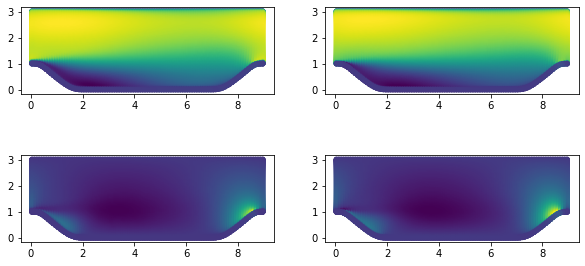

In [20]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,5))

ax[0,0].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['labels_um'],s=20)
ax[0,0].set_aspect(1)

ax[1,0].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['labels_vm'],s=20)
ax[1,0].set_aspect(1)

ax[0,1].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['komega_Ux'],s=20)
ax[0,1].set_aspect(1)

ax[1,1].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['komega_Uy'],s=20)
ax[1,1].set_aspect(1)


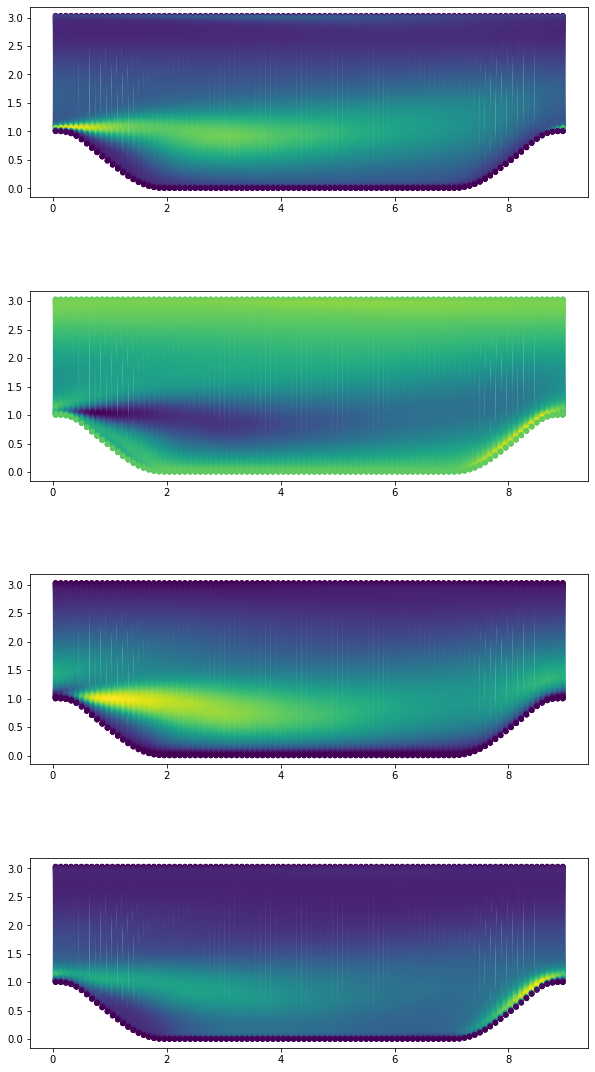

In [21]:
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(10,20))

ax[0].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['labels_uu'],s=20)
ax[0].set_aspect(1)

ax[1].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['labels_uv'],s=20)
ax[1].set_aspect(1)

ax[2].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['labels_vv'],s=20)
ax[2].set_aspect(1)

ax[3].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['labels_ww'],s=20)
ax[3].set_aspect(1)


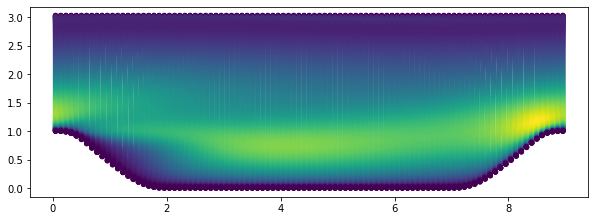

In [22]:
fieldname = 'komega_k'

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
ax.scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll[fieldname],s=20)
ax.set_aspect(1)

In [24]:
#Note: the input feature set is a hyperparameter. For now, let's use these arbitrary input features:
features = ['komega_I1_1','komega_I2_1','komega_I1_2','komega_I2_2','komega_I1_27','komega_I2_7']
label = ['labels_uu']

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
df_train = df[(df.Case.isin(['PHLL_case_0p5','PHLL_case_0p8','PHLL_case_1p5']))]
df_val = df[df.Case == 'PHLL_case_1p0']
df_test = df[df.Case == 'PHLL_case_1p2']

def preprocess_dataset(df,features,labels):
    df_train = df[(df.Case.isin(['PHLL_case_0p5','PHLL_case_0p8','PHLL_case_1p5']))]
    df_val = df[df.Case == 'PHLL_case_1p0']
    df_test = df[df.Case == 'PHLL_case_1p2']
        
    train_features = (df_train[features].values)
    train_labels = (df_train[labels].values)
    
    val_features = (df_val[features].values)
    val_labels = (df_val[labels].values)
    
    test_features = (df_test[features].values)
    test_labels = (df_test[labels].values)
    
    feature_scaler = StandardScaler()
    x_train = (feature_scaler.fit_transform(train_features))
    x_val = (feature_scaler.transform(val_features))
    x_test = (feature_scaler.transform(test_features))

    label_scaler = StandardScaler()
    y_train = (label_scaler.fit_transform(train_labels))
    y_val = (label_scaler.transform(val_labels))
    y_test = (label_scaler.transform(test_labels))    
    return x_train, y_train, x_val, y_val, x_test, y_test, feature_scaler, label_scaler


def evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, label_scaler,train_predictions,val_predictions,test_predictions):
    fig = plt.figure(figsize=(15,5),constrained_layout=True)
    gs = fig.add_gridspec(2,2,hspace=0.,wspace=0.1)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[0,1])
    ax4 = fig.add_subplot(gs[1,1])
    
    
    print(f'Training set score: {mean_squared_error(label_scaler.inverse_transform(y_train),label_scaler.inverse_transform(train_predictions))}')
    print(f'Validation set score: {mean_squared_error(label_scaler.inverse_transform(y_val),label_scaler.inverse_transform(val_predictions))}')
    print('=========================')
    print(f'TEST SET SCORE: {mean_squared_error(label_scaler.inverse_transform(y_test),label_scaler.inverse_transform(test_predictions))}\n')

    
    ax1.tricontourf(df_val['komega_Cx'],df_val['komega_Cy'],label_scaler.inverse_transform(val_predictions)[:,0],vmax=5E-5,vmin=-5E-5)
    ax1.set_aspect(1)
    ax1.set_title('Predictions - validation set')
    ax2.tricontourf(df_val['komega_Cx'],df_val['komega_Cy'],df_val['labels_uu'],vmax=5E-5,vmin=-5E-5)
    ax2.set_aspect(1)
    ax2.set_title('Truth - validation set')
    ax3.tricontourf(df_test['komega_Cx'],df_test['komega_Cy'],label_scaler.inverse_transform(test_predictions)[:,0],vmax=5E-5,vmin=-5E-5)
    ax3.set_aspect(1)
    ax3.set_title('Predictions - test set')
    ax4.tricontourf(df_test['komega_Cx'],df_test['komega_Cy'],df_test['labels_uu'],vmax=5E-5,vmin=-5E-5)
    ax4.set_aspect(1)
    ax4.set_title('Truth - test set')


## Random Forest Implementation
Random Forest is a powerful ensemble learning method used for both classification and regression tasks. It operates by constructing multiple decision trees during training and outputs the mode of the classes (classification) or the mean prediction (regression) of the individual trees. Each tree in the forest is trained on a random subset of the training data, and during prediction, the output is averaged over all the trees, reducing overfitting and increasing robustness to noisy data.

sklearn.ensemble.RandomForestRegressor is a module in scikit-learn library that implements Random Forest specifically for regression tasks. It allows you to train a regression model using the Random Forest algorithm. You can adjust parameters such as the number of trees in the forest, the maximum depth of the trees, and the number of features to consider when looking for the best split, among others. This flexibility enables you to fine-tune the model according to the characteristics of your dataset and the requirements of your regression problem.

In [26]:
from sklearn.ensemble import RandomForestRegressor as RFR
features = ['komega_I1_1','komega_I2_1','komega_I1_2','komega_I2_2','komega_I1_27','komega_I2_7']
labels = ['labels_uu']
x_train, y_train, x_val, y_val, x_test, y_test, feature_scaler, label_scaler = preprocess_dataset(df,features,labels)

model = RFR()
model.fit(x_train,y_train.ravel())
train_predictions = model.predict(x_train)
val_predictions = model.predict(x_val)
test_predictions = model.predict(x_test)

In [27]:
train_predictions=train_predictions.reshape((-1,1))
val_predictions=val_predictions.reshape((-1,1))
test_predictions=test_predictions.reshape((-1,1))

Training set score: 9.747606070738723e-12
Validation set score: 6.382263042264165e-11
TEST SET SCORE: 6.623858413402079e-11



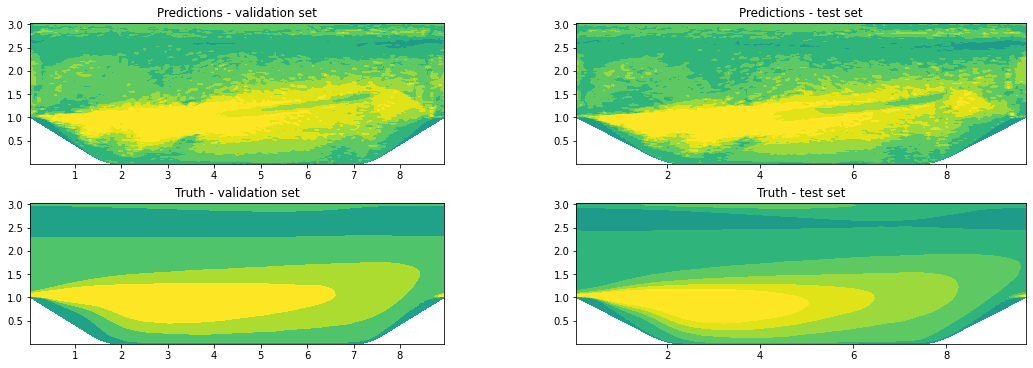

In [32]:
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, label_scaler,train_predictions,val_predictions,test_predictions)